# Goal 
Train a deep MLP on the MNIST dataset (you can load it using
keras.datasets.mnist.load_data(). See if you can get over
98% precision. Try searching for the optimal learning rate by
using the approach presented in this chapter (i.e., by growing the
learning rate exponentially, plotting the error, and finding the
point where the error shoots up). Try adding all the bells and
whistles—save checkpoints, use early stopping, and plot learning
curves using TensorBoard.

# Set Up

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Build an image classifier

In [2]:
tf.__version__

'2.2.0'

In [3]:
from tensorflow import keras
keras.__version__

'2.3.0-tf'

The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set

In [5]:
digit_mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = digit_mnist.load_data()

11493376/11490434 [==============================] - 41s 4us/step


In [6]:
print(X_train_full.shape)
print(y_train_full.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [7]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's imshow() function, with a 'binary' color map:

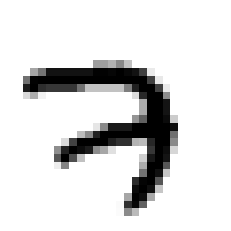

In [8]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [9]:
y_train[0]

7

In [10]:
# The labels are the class IDs (represented as uint8), from 0 to 9:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

Saving figure digit_mnist_plot


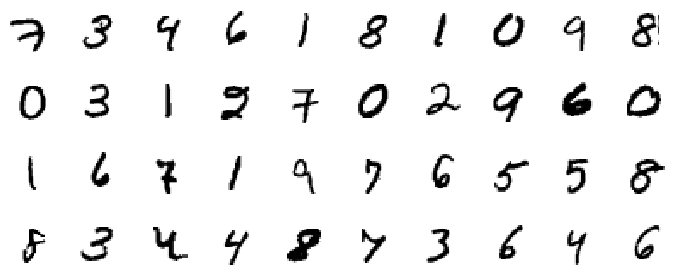

In [13]:
# Let's take a look at a sample of the images in the dataset:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('digit_mnist_plot', tight_layout=False)
plt.show()

## Let's build a main model just like in chap 10 note book.

In [61]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [62]:
model.layers

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [64]:
hidden0 = model.layers[0]
hidden0.name

'flatten'

In [65]:
hidden2 = model.layers[2]
weights2, biases2 = hidden2.get_weights()
weights2

array([[ 0.04602376, -0.0038019 ,  0.10557164, ...,  0.05382182,
        -0.09810888,  0.10975555],
       [-0.0131605 , -0.0401491 , -0.01301397, ..., -0.06764732,
        -0.05142808, -0.10832162],
       [ 0.0748878 ,  0.11689269,  0.06693598, ...,  0.04704887,
        -0.04119989,  0.1031863 ],
       ...,
       [-0.08606555,  0.1186113 , -0.11932244, ...,  0.1080649 ,
        -0.10135629,  0.05048553],
       [-0.1144025 , -0.06622341,  0.00440084, ..., -0.00439373,
         0.01447021,  0.02337808],
       [-0.10965011,  0.05632766,  0.11904002, ..., -0.0713827 ,
         0.11915682, -0.10558839]], dtype=float32)

Right now the weights are initialized at random, with the mean of 0 and variance of 1. We will try different weights initialization later.

In [66]:
weights2.shape

(300, 100)

In [67]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [68]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6196 - accuracy: 0.8405 - val_loss: 0.3103 - val_accuracy: 0.9120
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2954 - accuracy: 0.9151 - val_loss: 0.2473 - val_accuracy: 0.9304
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2430 - accuracy: 0.9302 - val_loss: 0.2060 - val_accuracy: 0.9428
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2076 - accuracy: 0.9405 - val_loss: 0.1824 - val_accuracy: 0.9494
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1811 - accuracy: 0.9486 - val_loss: 0.1644 - val_accuracy: 0.9540
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1603 - accuracy: 0.9542 - val_loss: 0.1482 - val_accuracy: 0.9602
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1431 - accuracy: 0.9598 - val_loss: 0.1366 - val_accuracy:

In [69]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [70]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


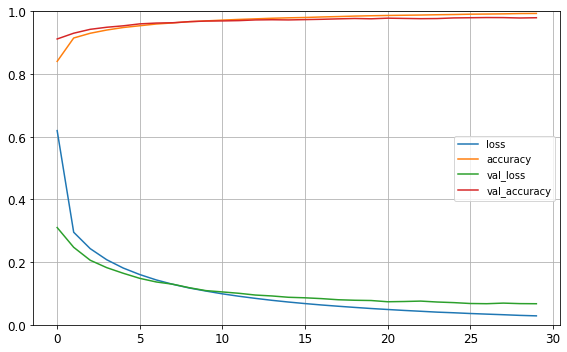

In [71]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [72]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0693 - accuracy: 0.9798


[0.0692683681845665, 0.9797999858856201]

In [73]:
y_proba = model.predict(X_test[:3])
y_proba.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [45]:
y_test[:3]

array([7, 2, 1], dtype=uint8)

# Bells and Whistles

## Saving and Restoring

In [46]:
model.save("main_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: main_model\assets


In [48]:
load_main_model = keras.models.load_model("main_model")
load_main_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.predict(X_test[3:7]).round(2)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [50]:
y_test[3:7]

array([0, 4, 1, 4], dtype=uint8)

In [51]:
model_load_weights = keras.models.Sequential()
model_load_weights.add(keras.layers.Flatten(input_shape=[28, 28]))
model_load_weights.add(keras.layers.Dense(300, activation="relu"))
model_load_weights.add(keras.layers.Dense(100, activation="relu"))
model_load_weights.add(keras.layers.Dense(10, activation="softmax"))

In [52]:
model.save_weights("main_model_weights.ckpt")
model_load_weights.load_weights("main_model_weights.ckpt")

In [53]:
model_load_weights.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [54]:
model_load_weights.predict(X_test[3:7]).round(2)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

##### Transfer Learning

However, when you save model A and load it into model B, any change to model B will also affect model A. To avoid this, you will need to clone it using clone_model().

In [55]:
main_model_clone = keras.models.clone_model(model)
main_model_clone.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


## Using Callbacks during Training

In [74]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [75]:
model_cb = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [79]:
model_cb.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [80]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("main_model_cb", save_best_only=True)
history = model_cb.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model_cb = keras.models.load_model("main_model_cb") # rollback to best model
model_cb.evaluate(X_test, y_test)

Epoch 1/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.6196 - accuracy: 0.8405 - val_loss: 0.3103 - val_accuracy: 0.9120
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2954 - accuracy: 0.9151 - val_loss: 0.2473 - val_accuracy: 0.9304
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2430 - accuracy: 0.9302 - val_loss: 0.2060 - val_accuracy: 0.9428
Epoch 4/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2076 - accuracy: 0.9405 - val_loss: 0.1824 - val_accuracy: 0.9494
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1811 - accuracy: 0.9486 - val_loss: 0.1644 - val_accuracy: 0.9540
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1603 - accuracy: 0.9542 - val_loss: 0.1482 - val_accuracy: 0.9602
Epoch 7/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1431 - accuracy: 0.9598 - val_loss: 0.1366 - val_accuracy:

[0.0692683681845665, 0.9797999858856201]

## TensorBoard

In [81]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [82]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2020_05_25-21_45_16'

In [83]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [84]:
model_tensor = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])    

# compile 
model_tensor.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [85]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model_tensor.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6196 - accuracy: 0.8405 - val_loss: 0.3103 - val_accuracy: 0.9120
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2954 - accuracy: 0.9151 - val_loss: 0.2473 - val_accuracy: 0.9304
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2430 - accuracy: 0.9302 - val_loss: 0.2060 - val_accuracy: 0.9428
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2076 - accuracy: 0.9405 - val_loss: 0.1824 - val_accuracy: 0.9494
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1811 - accuracy: 0.9486 - val_loss: 0.1644 - val_accuracy: 0.9540
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1603 - accuracy: 0.9542 - val_loss: 0.1482 - val_accuracy: 0.9602
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1431 - accuracy: 0.9598 - val_loss: 0.1366 - val_accuracy:

In [86]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 4740.

//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

## Learning Rate

Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up)

In [98]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [99]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [100]:
model_lr = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])    

# compile 
model_lr.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [101]:
expon_lr = ExponentialLearningRate(factor=1.005)

In [102]:
history = model_lr.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 4s 2ms/step - loss: 368436281344.0000 - accuracy: 0.5679 - val_loss: 2.3911 - val_accuracy: 0.1126


Text(0, 0.5, 'Loss')

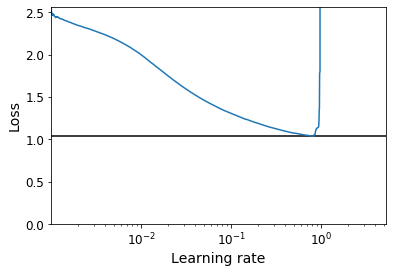

In [104]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [112]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [113]:
model_lr = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [114]:
model_lr.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2e-1),
              metrics=["accuracy"])

In [115]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'.\\my_mnist_logs\\run_001'

In [116]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("digit_mnist_model_lr", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model_lr.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2379 - accuracy: 0.9270 - val_loss: 0.1022 - val_accuracy: 0.9696
Epoch 2/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0946 - accuracy: 0.9711 - val_loss: 0.0895 - val_accuracy: 0.9752
Epoch 3/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0638 - accuracy: 0.9795 - val_loss: 0.0687 - val_accuracy: 0.9806
Epoch 4/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0463 - accuracy: 0.9847 - val_loss: 0.0798 - val_accuracy: 0.9772
Epoch 5/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0331 - accuracy: 0.9888 - val_loss: 0.0750 - val_accuracy: 0.9802
Epoch 6/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0252 - accuracy: 0.9913 - val_loss: 0.0741 - val_accuracy: 0.9788
Epoch 7/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0200 - accuracy: 0.9939 - val_loss: 0.0857 - val_ac

In [117]:
model_lr = keras.models.load_model("digit_mnist_model_lr") # rollback to best model
model_lr.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0712 - accuracy: 0.9776


[0.07122038304805756, 0.9775999784469604]

In [120]:
%tensorboard --logdir=./my_mnist_logs --port=6006

Reusing TensorBoard on port 6006 (pid 16848), started 0:04:59 ago. (Use '!kill 16848' to kill it.)

## Hyperparameters tuning

### Now that we know the best learning rate, let's play around with number of layers, number of neurons per layer and callbacks using Randomized Search

### Callbacks

In [121]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [122]:
run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2020_05_26-13_54_51'

In [123]:
model_cb = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])    

# compile 
model_cb.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2e-1),
              metrics=["accuracy"])

In [125]:
earlystopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
modelcheckpoint_cb = keras.callbacks.ModelCheckpoint('model_cb.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model_cb.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystopping_cb, tensorboard_cb, modelcheckpoint_cb])

Epoch 1/100
1707/1719 [============================>.] - ETA: 0s - loss: 0.2387 - accuracy: 0.9268
Epoch 00001: val_accuracy improved from -inf to 0.96960, saving model to model_cb.h5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2379 - accuracy: 0.9270 - val_loss: 0.1022 - val_accuracy: 0.9696
Epoch 2/100
1701/1719 [============================>.] - ETA: 0s - loss: 0.0944 - accuracy: 0.9711
Epoch 00002: val_accuracy improved from 0.96960 to 0.97520, saving model to model_cb.h5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0946 - accuracy: 0.9711 - val_loss: 0.0895 - val_accuracy: 0.9752
Epoch 3/100
1703/1719 [============================>.] - ETA: 0s - loss: 0.0641 - accuracy: 0.9794
Epoch 00003: val_accuracy improved from 0.97520 to 0.98060, saving model to model_cb.h5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0638 - accuracy: 0.9795 - val_loss: 0.0687 - val_accuracy: 0.9806
Epoch 4/100
1710/1719 [====================

Epoch 00027: early stopping


In [126]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6900), started 15:24:46 ago. (Use '!kill 6900' to kill it.)

In [127]:
model_cb = keras.models.load_model("model_cb.h5") # rollback to best model
model_cb.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0746 - accuracy: 0.9837


[0.07456400245428085, 0.9836999773979187]

**///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////** 

Yay we got above 98 accuracy 

**///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////** 

# Progress Note

**Problem 1:**

When I use "checkpoint_cb = keras.callbacks.ModelCheckpoint("main_model_cb", save_best_only=True)", does it mean that after each epoch, it will save the weights if the accuracy of this epoch is better than the previous one?

After I include ModelCheckpoint in .fit(), the final accuracy is the same as before when I did not include it. Does this mean the last epoch was the best result? Maybe if I train it for 100 epoch, it will start overfitting and then ModelCheckpoint might actually help? 

**Problem 2:**

Function ExponentialLearningRate supposes to return a callbacks object. Which arms/legs does a callback object have? 

**Investigation 3:**

**Investigation 4: callbacks.Earlystopping()**

monitor: Quantity to be monitored.

min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.

patience: Number of epochs with no improvement after which training will be stopped.

verbose: verbosity mode.

mode: One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.

baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.

restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.

-----What is the default value for Monitor and min_delta?-----

Go to this link: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/. It has everything to know about Earlystopping and Checkpoints. It also has an example of a overfitted network for a binary classification problem, which can be helpful for the honor thesis. 

- Monitor: val_loss. We can also use "loss", "accuracy", "val_accuracy"
- min_delta: ?
- verbose: To discover the training epoch on which training was stopped, the “verbose” argument can be set to 1. Once stopped, the callback will print the epoch number

**Investigation 5: Compile**

What is the list of matrics for matrics argument?

**Investigation 6: Tensorboard visulization from Hyperparameter tuning: Callbacks**

Weird shape in the first 2 to 3 epochs.

**Investigation 7: How to apply knowledge learned in chapp 11 into Jupyter Notebook**